In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

from sklearn.preprocessing import StandardScaler
import pickle

from sklearn.metrics import r2_score

- Import data.

In [2]:
epi = pd.read_csv('../data/dataframes/epi_cleaned.csv')
epi.drop(columns = 'Unnamed: 0', inplace = True)

- Drop columns that are a combination of other features.

In [3]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water']

In [4]:
epi.drop(columns = precomputed, inplace = True)

- Multi-index country and year.

In [5]:
years = sorted(set(epi['year'].values))
min_year = years[0]
max_year = years[-1]

In [12]:
indices = []
for country in set(epi['country_name'].to_dict().values()):
    country_years = sorted(set(epi[epi['country_name'] == country]['year'].values))
    country_min_year = country_years[0]
    country_max_year = country_years[-1]
    
    for year in range(country_min_year, country_max_year + 1):   
        indices.append((country, year))

In [13]:
epi_new = pd.DataFrame(data = epi, columns = epi.columns, index = pd.MultiIndex.from_tuples(indices, names=["country_name", "year"]), copy = True)

In [16]:
%%capture
for country in set(list(epi['country_name'].to_dict().values())):
    for year in range(min_year, max_year + 1):
        try:
            epi_new.loc[(country, year)] = epi[(epi['country_name'] == country) & (epi['year'] == year)].iloc[0]
        except:
            pass

In [17]:
epi_new.drop(columns = ['country_name', 'year'], inplace = True)

In [22]:
epi = epi_new.copy()

- Model OLS, LASSO, Ridge per year.

In [24]:
x_list = epi.columns.tolist()
x_list.remove('Environmental Performance Index')

In [25]:
def quick_ttt(df):
    X = df[x_list]
    y = df['Environmental Performance Index']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    return X_train, X_test, y_train, y_test

In [28]:
%%capture
models = {}
for year in range(min_year, max_year + 1):
    year_frame = epi.loc[(slice(None), year), :]
    year_models = {}
    
    X_train, X_test, y_train, y_test = quick_ttt(year_frame)
    
    #OLS
    lr = LinearRegression(n_jobs = 8)
    lr.fit(X_train, y_train)
    
    train_preds = lr.predict(X_train)
    test_preds = lr.predict(X_test)
    
    year_models['OLS'] = {'model': lr, 'train_score': r2_score(y_train, train_preds), 'test_score': r2_score(y_test, test_preds)}
    
    sc = StandardScaler()
    
    Xs_train = sc.fit_transform(X_train)
    Xs_test = sc.transform(X_test)
    
    #LASSO    
    lasso = Lasso(random_state = 42, selection = 'random')
    
    lasso_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }
    
    lasso_bs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                             cv = 5, n_jobs = 8, random_state = 42)
    
    lasso_bs.fit(Xs_train, y_train)
    
    lasso_train_preds = lasso_bs.predict(Xs_train)
    lasso_test_preds = lasso_bs.predict(Xs_test)
    
    year_models['LASSO'] =  {'model': lasso_bs.best_estimator_, 'train_score': r2_score(y_train, lasso_train_preds), 'test_score': r2_score(y_test, lasso_test_preds)}
    
    #Ridge
    ridge = Ridge(random_state = 42)
    
    ridge_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }
    
    ridge_bs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params, cv = 5, n_jobs = 8, random_state = 42)
    ridge_bs.fit(Xs_train, y_train)
    
    ridge_train_preds = ridge_bs.predict(Xs_train)
    ridge_test_preds = ridge_bs.predict(Xs_test)
    
    year_models['Ridge'] =  {'model': ridge_bs.best_estimator_, 'train_score': r2_score(y_train, ridge_train_preds), 'test_score': r2_score(y_test, ridge_test_preds)}
    
    models[year] = year_models

- Make dataframe for model coefficients

In [29]:
indices = []
for model in list(year_models.keys()):
    for year in range(min_year, max_year + 1):   
        indices.append((model, year))

In [30]:
linear_frame = pd.DataFrame(columns = x_list, index = pd.MultiIndex.from_tuples(indices, names=["model", "year"]))

- Fill model coefficient dataframe

In [31]:
for model in list(year_models.keys()):
    for year in range(min_year, max_year + 1):
        pairs = zip(x_list, list(models[year][model]['model'].coef_))
        pairs = {key: value for key, value in pairs}
        linear_frame.loc[(model, year)] = pd.Series(pairs)

- Plot model weights

In [32]:
linear_frame.loc['OLS'] = sc.fit_transform(linear_frame.loc['OLS'])

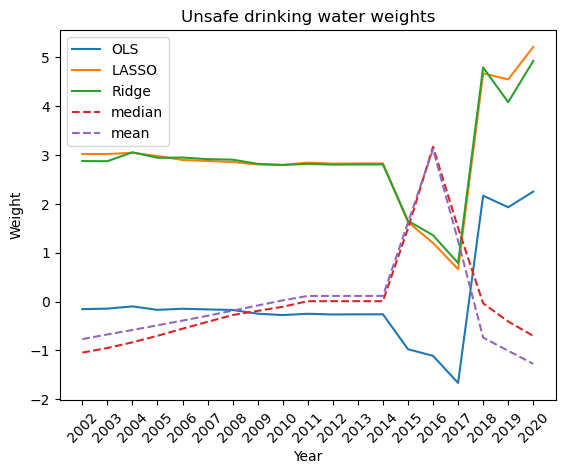

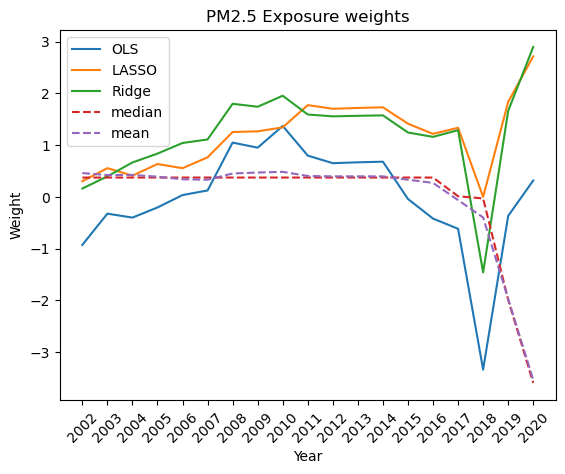

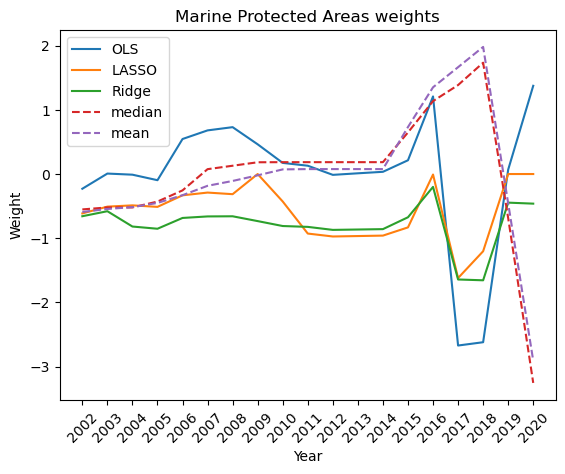

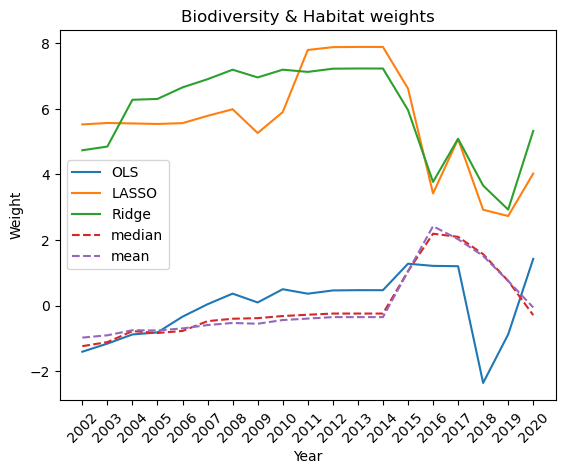

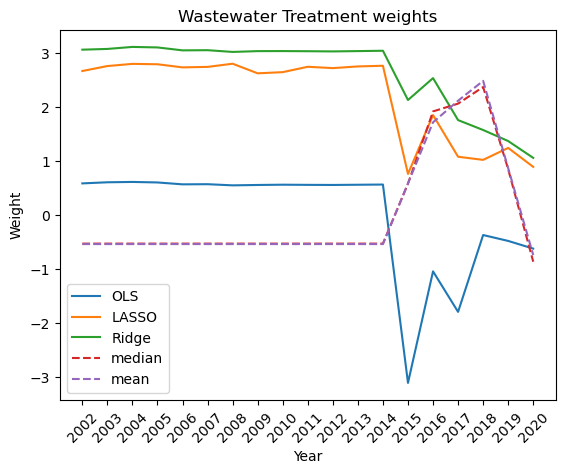

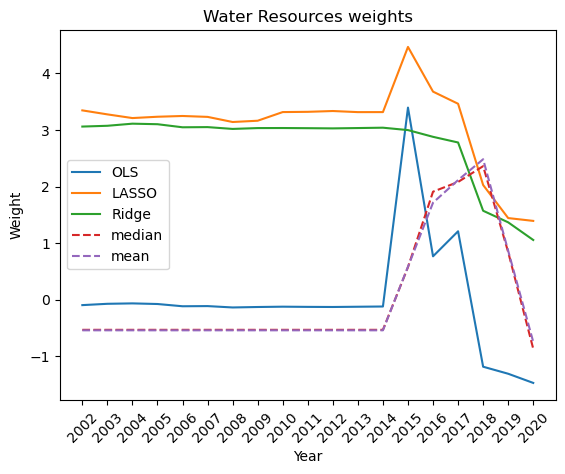

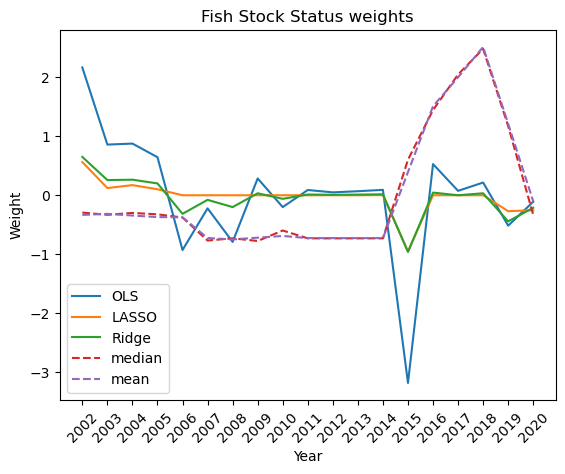

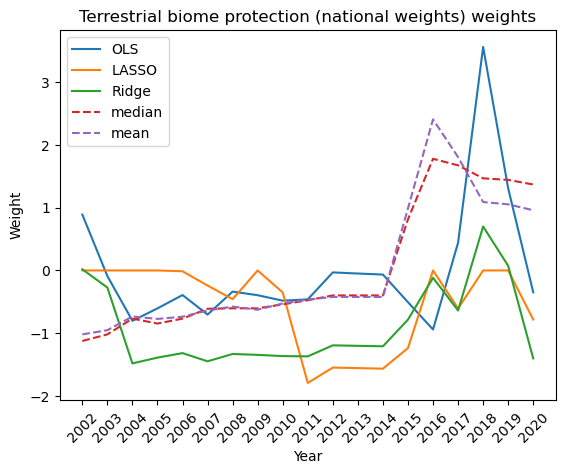

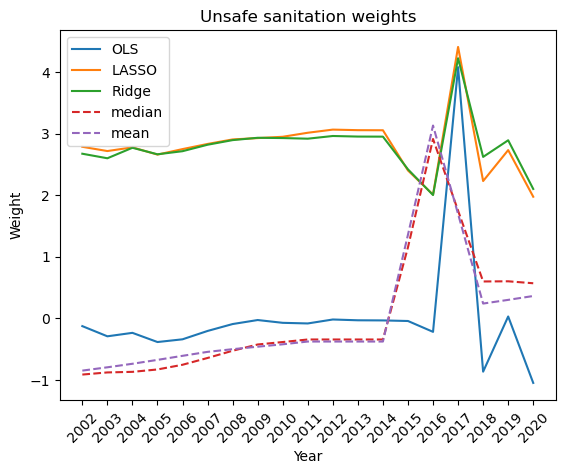

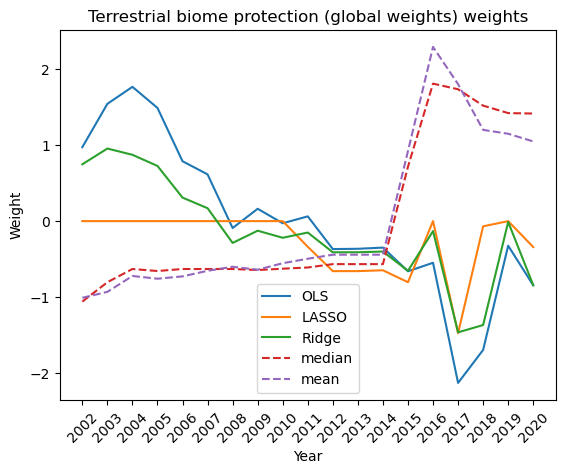

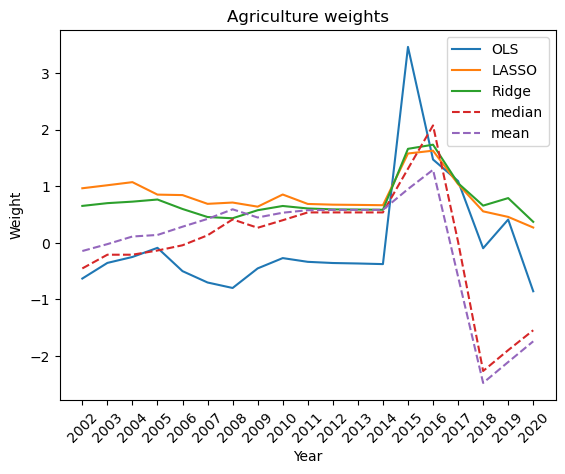

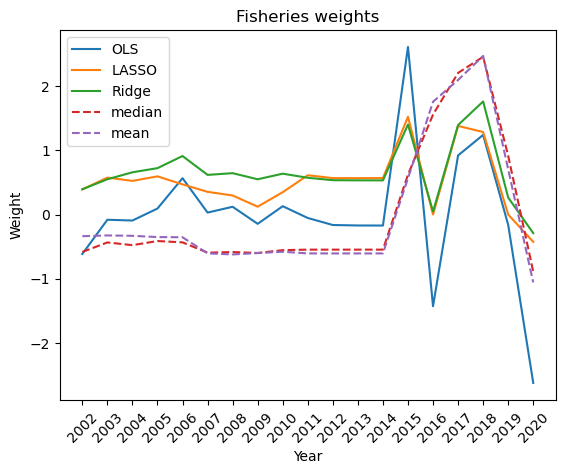

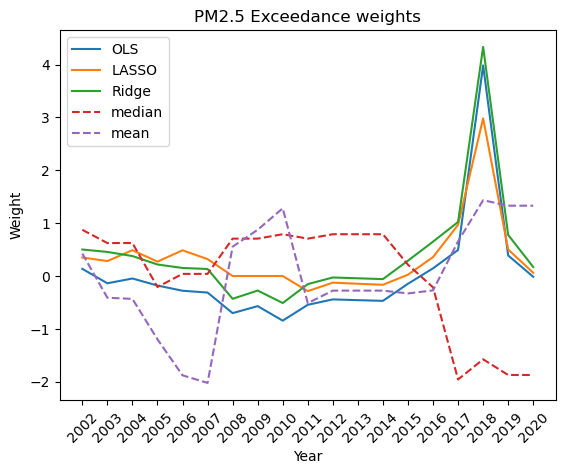

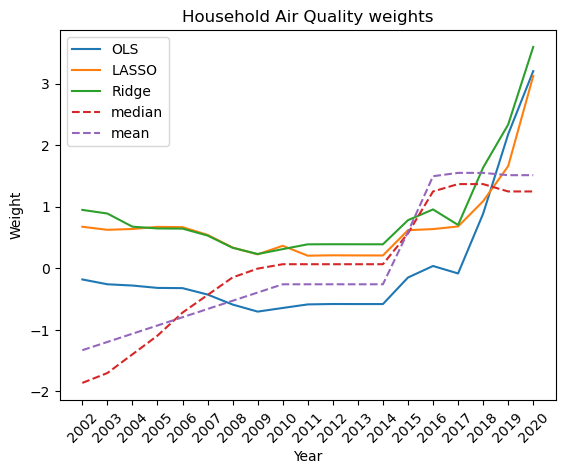

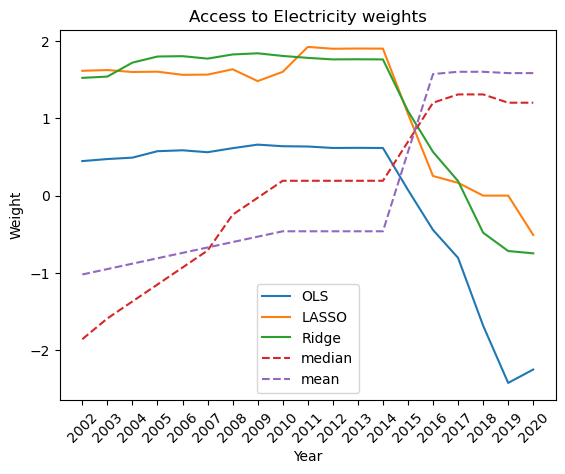

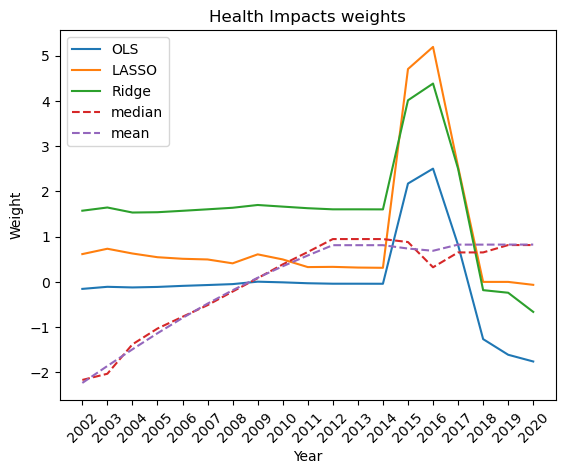

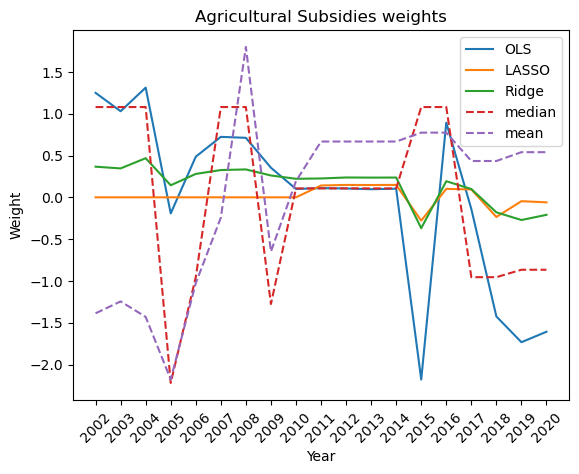

In [ ]:
model_names = list(year_models.keys())
#model_names.remove('OLS')

years = range(min_year, max_year + 1)

for col in x_list:
    for model in model_names:
        plt.plot(years, linear_frame.loc[model, col])
      
    medians = []
    means = []
    for year in years:
        medians.append(epi.loc[(slice(None), year), :][col].median())
        means.append(epi.loc[(slice(None), year), :][col].mean())
        
    plt.plot(years, sc.fit_transform(np.array(medians).reshape(-1,1)), '--')
    plt.plot(years, sc.fit_transform(np.array(means).reshape(-1,1)), '--')
    
    legend = []
    legend.extend(model_names)
    legend.append('median')
    legend.append('mean')
    
    plt.title(f'{col} weights')
    plt.xlabel('Year')
    plt.ylabel('Weight')
    plt.xticks(ticks = years, rotation = 45)
    plt.legend(legend)
    plt.show()